In [25]:
import numpy as np
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet

import jax
import jax.numpy as jnp
from jax import random, jit
from jax.random import PRNGKey

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import importlib

collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data

In [63]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho, y_ho, y_noisy_ho, true_derivatives_ho = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho = jnp.array(jnp.squeeze(y_noisy_ho))
t_ho = jnp.array(jnp.squeeze(t_ho))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
#weights_ho = compute_weights(t_ho)
#D_ho = np.array(lagrange_derivative(t_ho, weights_ho))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho, y_test_ho, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_ho, estimated_solution_ho = collocate_data(y_noisy_ho, t_ho, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [77]:
import nn_jax_diffrax
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE

In [78]:
y_pred_results = {}

layer_widths = [2, 64, 64, 2]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)
state = node_model.create_train_state(rng, learning_rate)

y0 = initial_state
for k in [50, 200]:
    state = node_model.train( state, t_ho[:k] 
                            , y_noisy_ho[:k], y0
                            , num_epochs = 2000
                            )

Epoch 100, Loss: 7.322026889921871
Epoch 200, Loss: 3.2486491717920467
Epoch 300, Loss: 3.0282478576850425
Epoch 400, Loss: 2.8324747533001986
Epoch 500, Loss: 2.750855855411227
Epoch 600, Loss: 2.7218601588027806
Epoch 700, Loss: 2.7075169611202057
Epoch 800, Loss: 2.693505906614284
Epoch 900, Loss: 2.6795098862943147
Epoch 1000, Loss: 2.6666071921923926
Epoch 1100, Loss: 2.654052566296364
Epoch 1200, Loss: 2.643257289281328
Epoch 1300, Loss: 2.625856568055846
Epoch 1400, Loss: 2.6101675713554284
Epoch 1500, Loss: 2.6018739631214864
Epoch 1600, Loss: 2.594973087007947
Epoch 1700, Loss: 2.591817499933766
Epoch 1800, Loss: 2.5925296595379903
Epoch 1900, Loss: 2.591360041873025
Epoch 2000, Loss: 2.5877386560511315
Epoch 100, Loss: 15.840709230955566
Epoch 200, Loss: 15.561674075418527
Epoch 300, Loss: 15.247016601592781
Epoch 400, Loss: 15.74937143469845
Epoch 500, Loss: 17.063788665462106
Epoch 600, Loss: 16.22321812500358
Epoch 700, Loss: 18.07772027571083
Epoch 800, Loss: 15.402307266

In [79]:
y_train_pred = node_model.neural_ode(state.params, initial_state, t_ho, state)

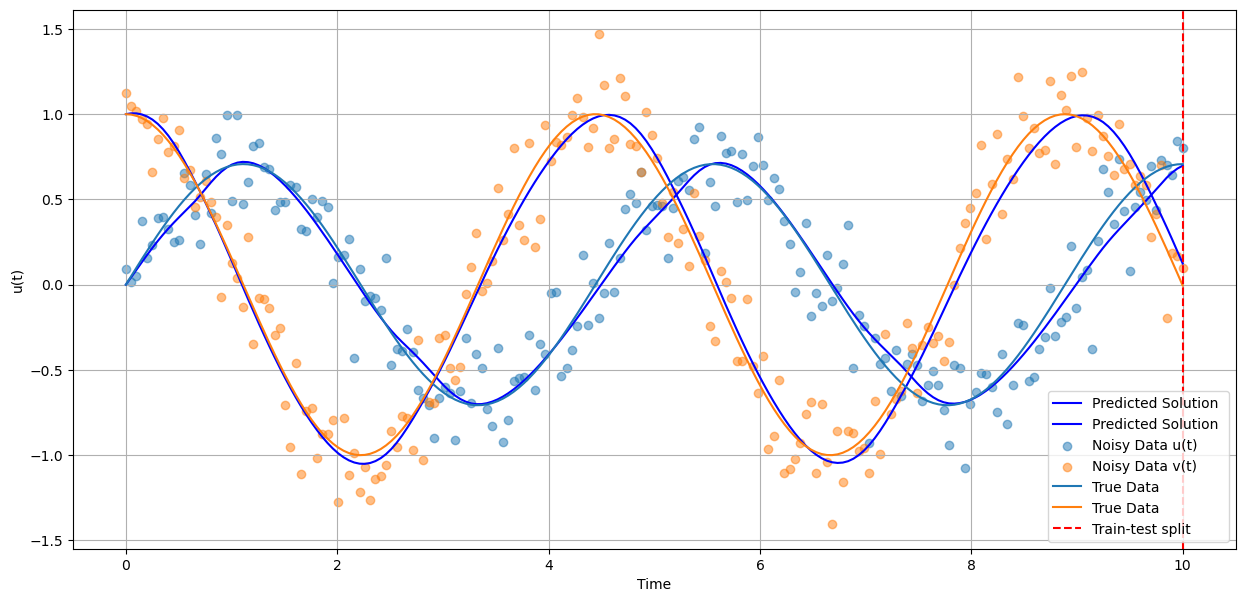

In [80]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_ho, y_train_pred, 'b', label='Predicted Solution ')
#plt.plot(t_test_vdp[N-1:], result['y_test_pred'], 'b', label='Predicted Solution')
#plt.plot(t_test_vdp, y_test_vdp, 'g--', label='True Solution')

plt.scatter(t_ho, y_noisy_ho.T[0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_ho, y_noisy_ho.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.plot(t_ho, y_ho, label='True Data', alpha = 1)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

---
---


In [24]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp, y_vdp, y_noisy_vdp, true_derivatives_vdp = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp = np.array(jnp.squeeze(y_noisy_vdp))
t_vdp = np.array(jnp.squeeze(t_vdp))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
#weights = compute_weights(t_vdp)
#D_vdp = np.array(lagrange_derivative(t_vdp, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_vdp, y_test_vdp, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
#estimated_derivative_vdp, estimated_solution_vdp = collocate_data(y_noisy_vdp, t_vdp, 'EpanechnikovKernel', bandwidth=0.5)

In [26]:
y_pred_results = {}

layer_widths = [3, 64, 64, 2]
learning_rate = 1e-3
rng = PRNGKey(0)

neural_ode_model = NeuralODE_JAX(layer_widths=layer_widths, time_invariant=False)
state = neural_ode_model.create_train_state(rng, learning_rate)

start_timer = time.time()
# train(self, state, t, observed_data, y0, num_epochs=1000):
trained_state = neural_ode_model.train(state, t_vdp, y_noisy_vdp, initial_state, num_epochs=10000)
end_timer = time.time()
timer = end_timer - start_timer
print(f"Time elapsed: {timer}")

y_train_pred = neural_ode_model.neural_ode(trained_state.params, initial_state, t_vdp, trained_state)

#---------------------------------------------SAVE RESULT---------------------------------------------#
y1 = y_train_pred[-1, :]
# def neural_ode(self, params, y0, t, state):
y_test_pred = neural_ode_model.neural_ode(trained_state.params, y1, t_test_vdp[N-1:], trained_state)
y_pred_results[1] = {"y_train_pred": y_train_pred, "y_test_pred": y_test_pred,
                            "time_elapsed": timer, "y_noisy":y_noisy_vdp}


Epoch 100, Loss: 1147.3245414074952
Epoch 200, Loss: 1136.1466330205153
Epoch 300, Loss: 1129.8715542389339
Epoch 400, Loss: 1124.2064098327805
Epoch 500, Loss: 1119.2771229501673
Epoch 600, Loss: 1114.7213244761174
Epoch 700, Loss: 1109.9561343613602
Epoch 800, Loss: 1104.429241102869
Epoch 900, Loss: 1097.5530011150086
Epoch 1000, Loss: 1120.4519734516737
Epoch 1100, Loss: 1082.1027707699386
Epoch 1200, Loss: 1071.2207815767792
Epoch 1300, Loss: 1058.7911576893357
Epoch 1400, Loss: 888.2187079279507
Epoch 1500, Loss: 622.1128663413508
Epoch 1600, Loss: 1116.4661405753143
Epoch 1700, Loss: 1069.5711894202934
Epoch 1800, Loss: 973.953172456461
Epoch 1900, Loss: 809.5417043817688
Epoch 2000, Loss: 294.7997259262744
Epoch 2100, Loss: 241.95274896798176
Epoch 2200, Loss: 164.0422818417171
Epoch 2300, Loss: 157.81052559548542
Epoch 2400, Loss: 166.45785134462173
Epoch 2500, Loss: 153.95377281109057
Epoch 2600, Loss: 147.5613976121579
Epoch 2700, Loss: 144.61356383077626
Epoch 2800, Loss: 1

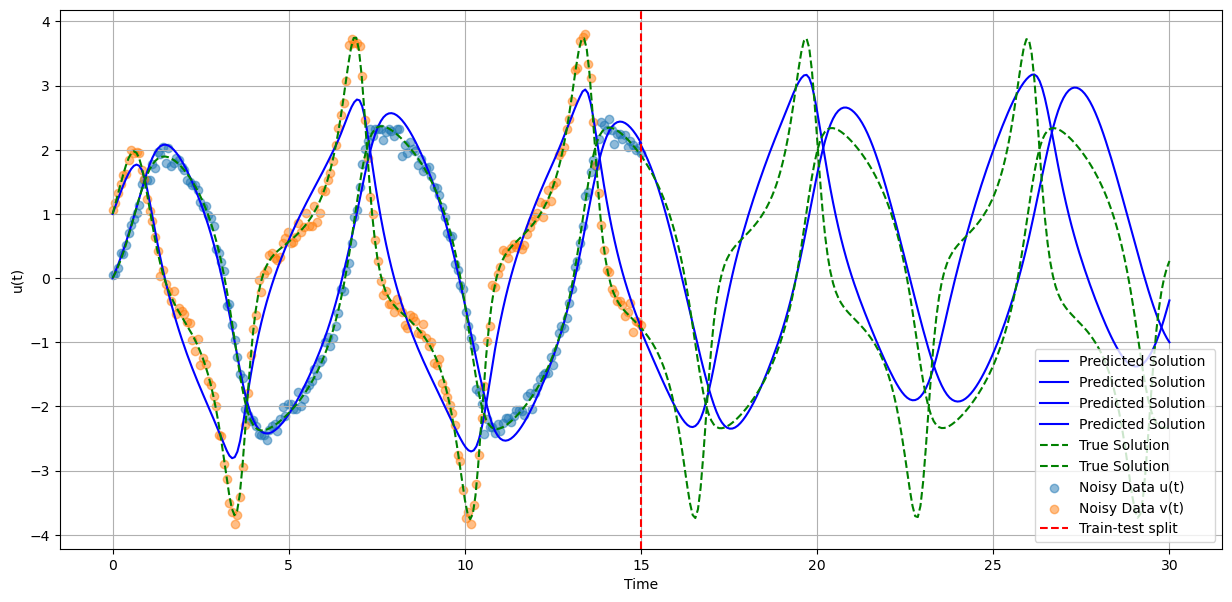

In [27]:
result = y_pred_results[1]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_vdp, result['y_train_pred'], 'b', label='Predicted Solution ')
plt.plot(t_test_vdp[N-1:], result['y_test_pred'], 'b', label='Predicted Solution')
plt.plot(t_test_vdp, y_test_vdp, 'g--', label='True Solution')

plt.scatter(t_vdp, y_noisy_vdp.T[0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_vdp, y_noisy_vdp.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=15, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()